In [21]:
import datetime
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers
# import backtest
import pandas as pd
import numpy as np
# import math
# import matplotlib.pyplot as plt

import akshare as ak
import seaborn as sns
import numpy as np
from scipy.stats import norm

import pyfolio as pf
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [ ]:
放量




缩量






In [22]:
rcParams['figure.figsize'] = (20, 10)

In [23]:
%matplotlib inline

In [24]:
df = ak.stock_zh_a_hist(symbol='603636', period='daily', start_date='20200101', end_date='20220810', adjust='qfq')

In [25]:
df.columns = ['date', 'open', 'close', 'high', 'low', 'volume', 'turnover', 'mplitude', 'change_rate', 'change_amount', 'turnover_rate']

In [26]:
df.set_index(pd.to_datetime(df['date']), drop=True, inplace=True)

In [27]:
df = df.drop(['date'], axis=1)

In [28]:
# df['av'] = df['turnover'] / df['volume']

In [29]:
# df['av_mean'] = df['av'].rolling(5, min_periods=1).mean()
# df['tr_mean'] = df['turnover_rate'].rolling(5, min_periods=1).mean()
# df['tr_sum'] = df['turnover_rate'].rolling(5, min_periods=1).sum()

In [30]:
df.head()

,open,close,high,low,volume,turnover,mplitude,change_rate,change_amount,turnover_rate
date,,,,,,,,,,
2020-01-02,11.08,11.31,11.42,11.02,68002,79126912.0,3.65,3.10,0.34,1.30
2020-01-03,11.35,11.33,11.56,11.26,90155,105656877.0,2.65,0.18,0.02,1.72
2020-01-06,11.24,11.40,11.54,11.21,127002,149282022.0,2.91,0.62,0.07,2.42
2020-01-07,11.47,11.68,11.69,11.34,144844,172459096.0,3.07,2.46,0.28,2.76
2020-01-08,11.57,11.54,11.99,11.50,166489,201448680.0,4.20,-1.20,-0.14,3.17


In [31]:
class PandasData(bt.feeds.PandasData):
    
#     linesoverride = True
    lines = ('volume', 'turnover', 'mplitude', 'change_rate', 'change_amount', 'turnover_rate', )
    
    params = (
#         ('datetime', None),
#         ('openinterest', None),
        
        ('open', 0),
        ('high', 2),
        ('low', 3),
        ('close', 1),

        ('volume', 4),
        ('turnover', 5),
        ('mplitude', 6),
        ('change_rate', 7),
        ('change_amount', 8),
        ('turnover_rate', 9),
        
    )

In [32]:
class VolumeCross(bt.Strategy):
    
    params = (('period', 5),)
    
    def __init__(self):
        self.sma_turnover_rate = btind.SMA(self.data0.turnover_rate, period=self.p.period, plot=False)
#         self.sma_turnover_rate15 = btind.SMA(self.data0.turnover_rate, period=7, plot=False)
#         self.crossover = btind.CrossOver(self.sma_turnover_rate, self.sma_turnover_rate15)


    def next(self):
#         if not self.position:
#             if self.crossover > 0:
#                 self.buy()
#         elif not self.crossover < 0:
#             self.close()
        
#         if not self.position:
#             if self.data0.close > self.sma_turnover_rate:
#                 self.buy()
#         elif self.data0.close < self.sma_turnover_rate:
#             self.close()

        if not self.position:
            if self.data0.turnover_rate / self.sma_turnover_rate[-1] > 2.5 and self.data0.change_rate < -4:
                self.buy()
        elif self.data0.turnover_rate / self.sma_turnover_rate[-1] < 1.5:
            self.close()
            

In [33]:
cerebro = bt.Cerebro(oldtrades=True)

data = PandasData(dataname=df)

cerebro.adddata(data)
# cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addstrategy(VolumeCross)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.broker = bt.brokers.BackBroker(slip_perc=0.02)

cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(0.0005)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run() #stdstats=False)

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10002.88


<IPython.core.display.Javascript object>


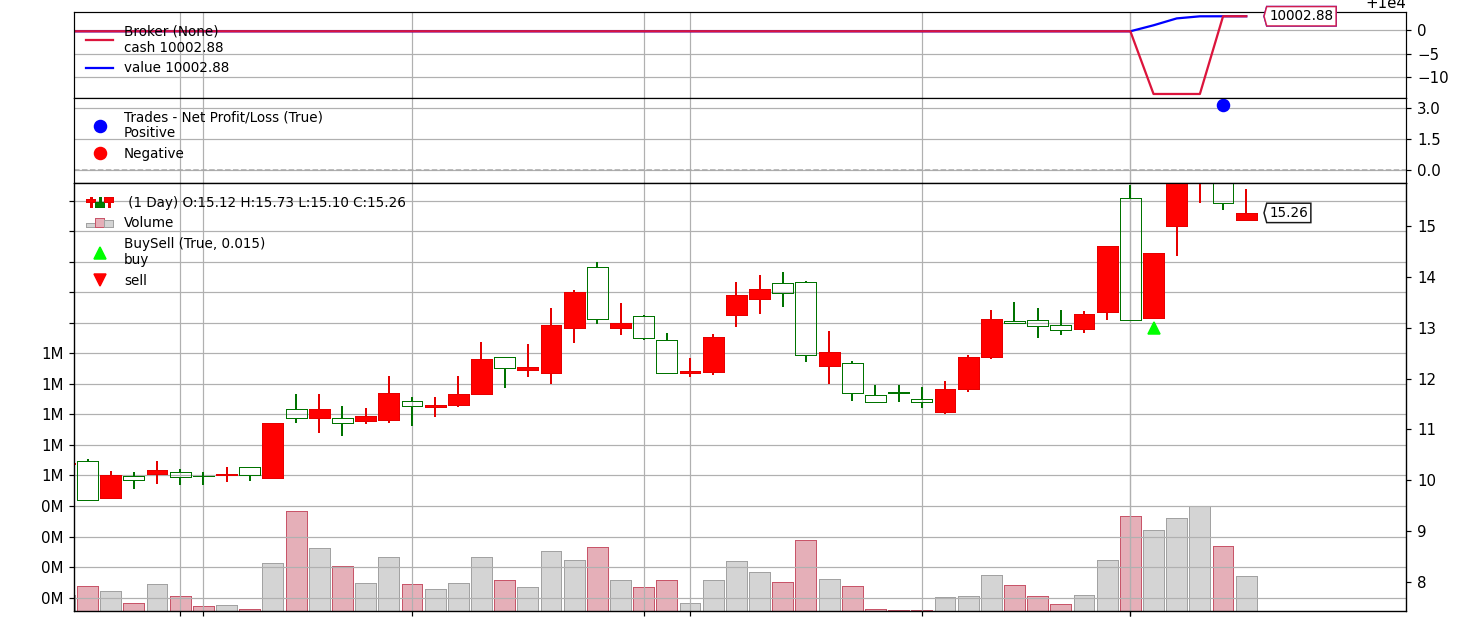

[[<Figure size 432x288 with 4 Axes>]]

In [35]:
cerebro.plot(
#     iplot=True,
#     start=datetime.date(2021, 1, 1),
#     end=datetime.date(2021, 11, 24),
    style='candlestick',
    barup='red',
    bardown='green',
    barupfill=True, 
    bardownfill=False,
)

In [17]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.07,2020-02-24,2021-11-02,2022-03-17,539
1,0.05,2022-03-21,2022-04-22,2022-07-26,92
2,0.03,2020-01-09,2020-02-03,2020-02-10,23
3,0.01,2022-07-26,2022-08-03,2022-08-05,9
4,0.01,2022-08-08,2022-08-09,NaT,NaN


d:\soft\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 60.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
d:\code\python\pyfolio\pyfolio\timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
New Normal,0.00%,-0.02%,0.02%


Top 10 long positions of all time,max
df0,0.19%


Top 10 short positions of all time,max


Top 10 positions of all time,max
df0,0.19%


d:\soft\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


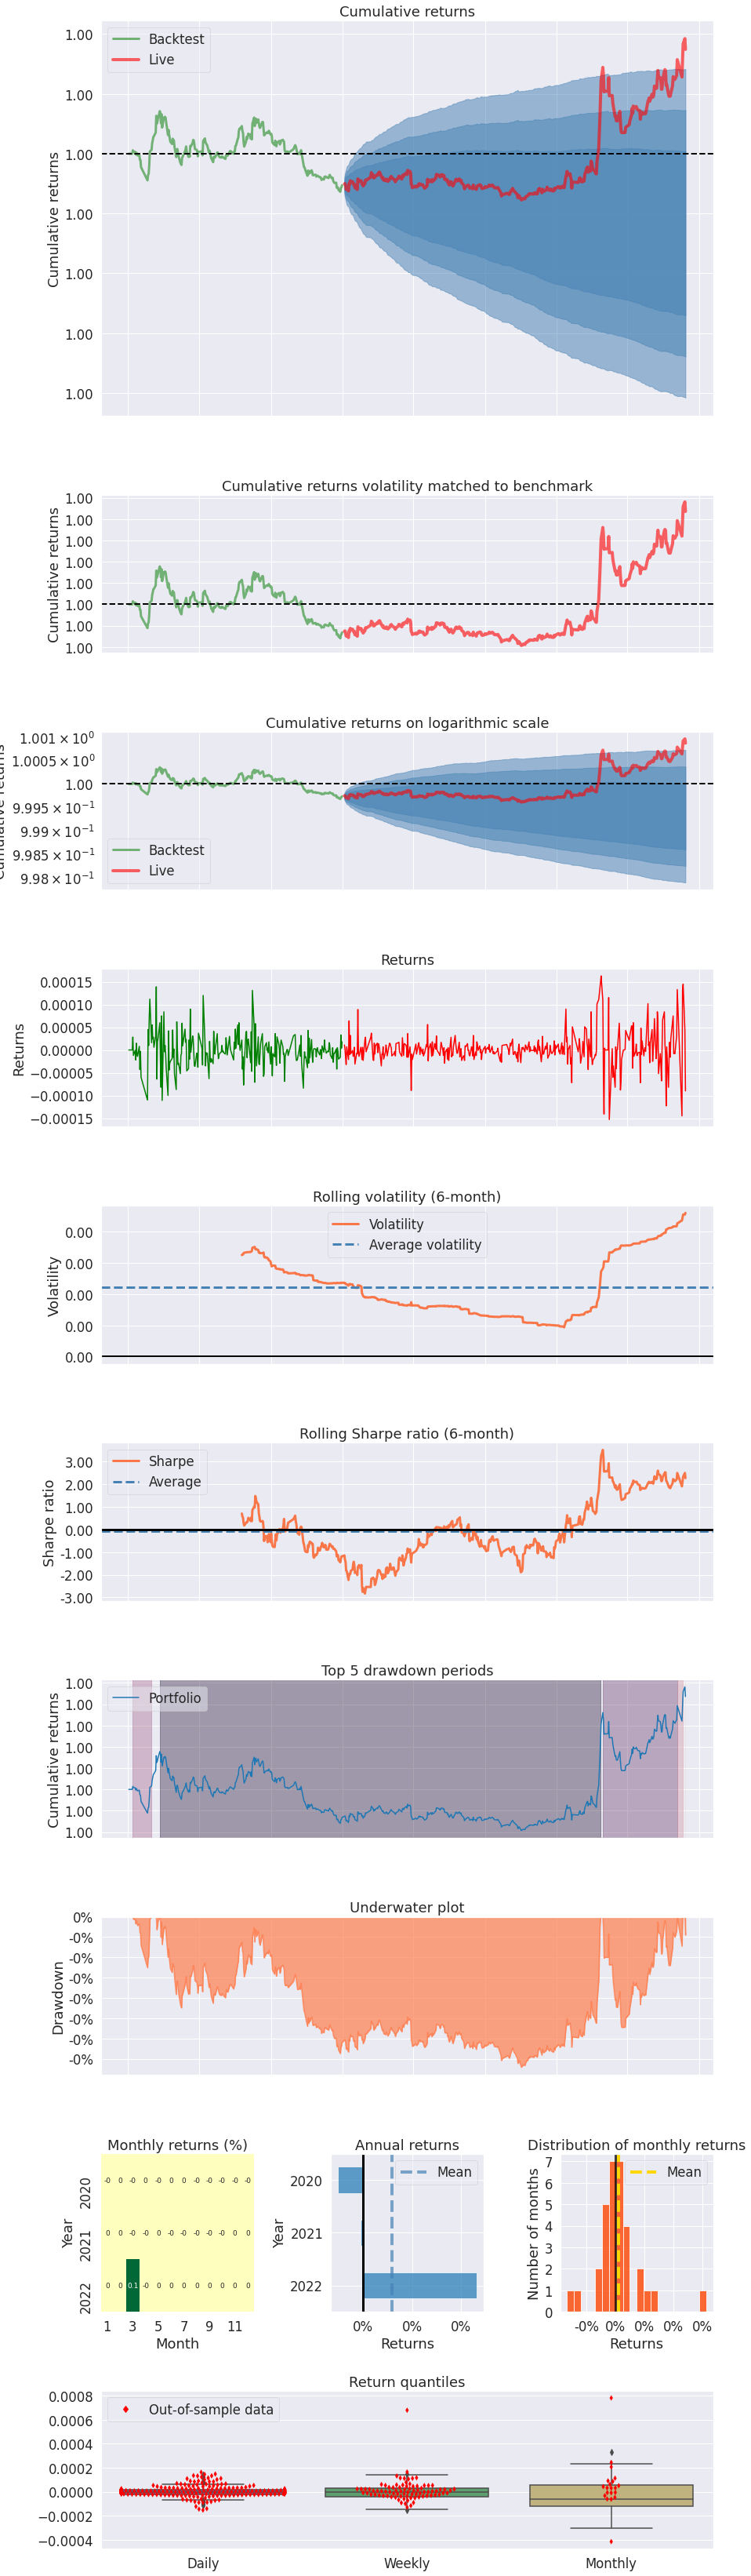

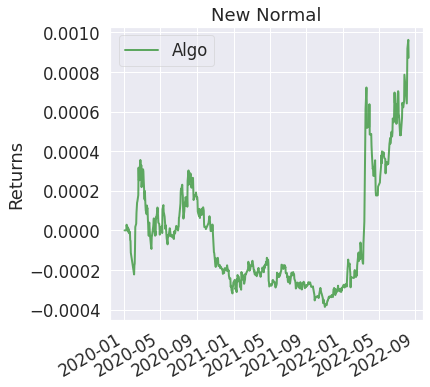

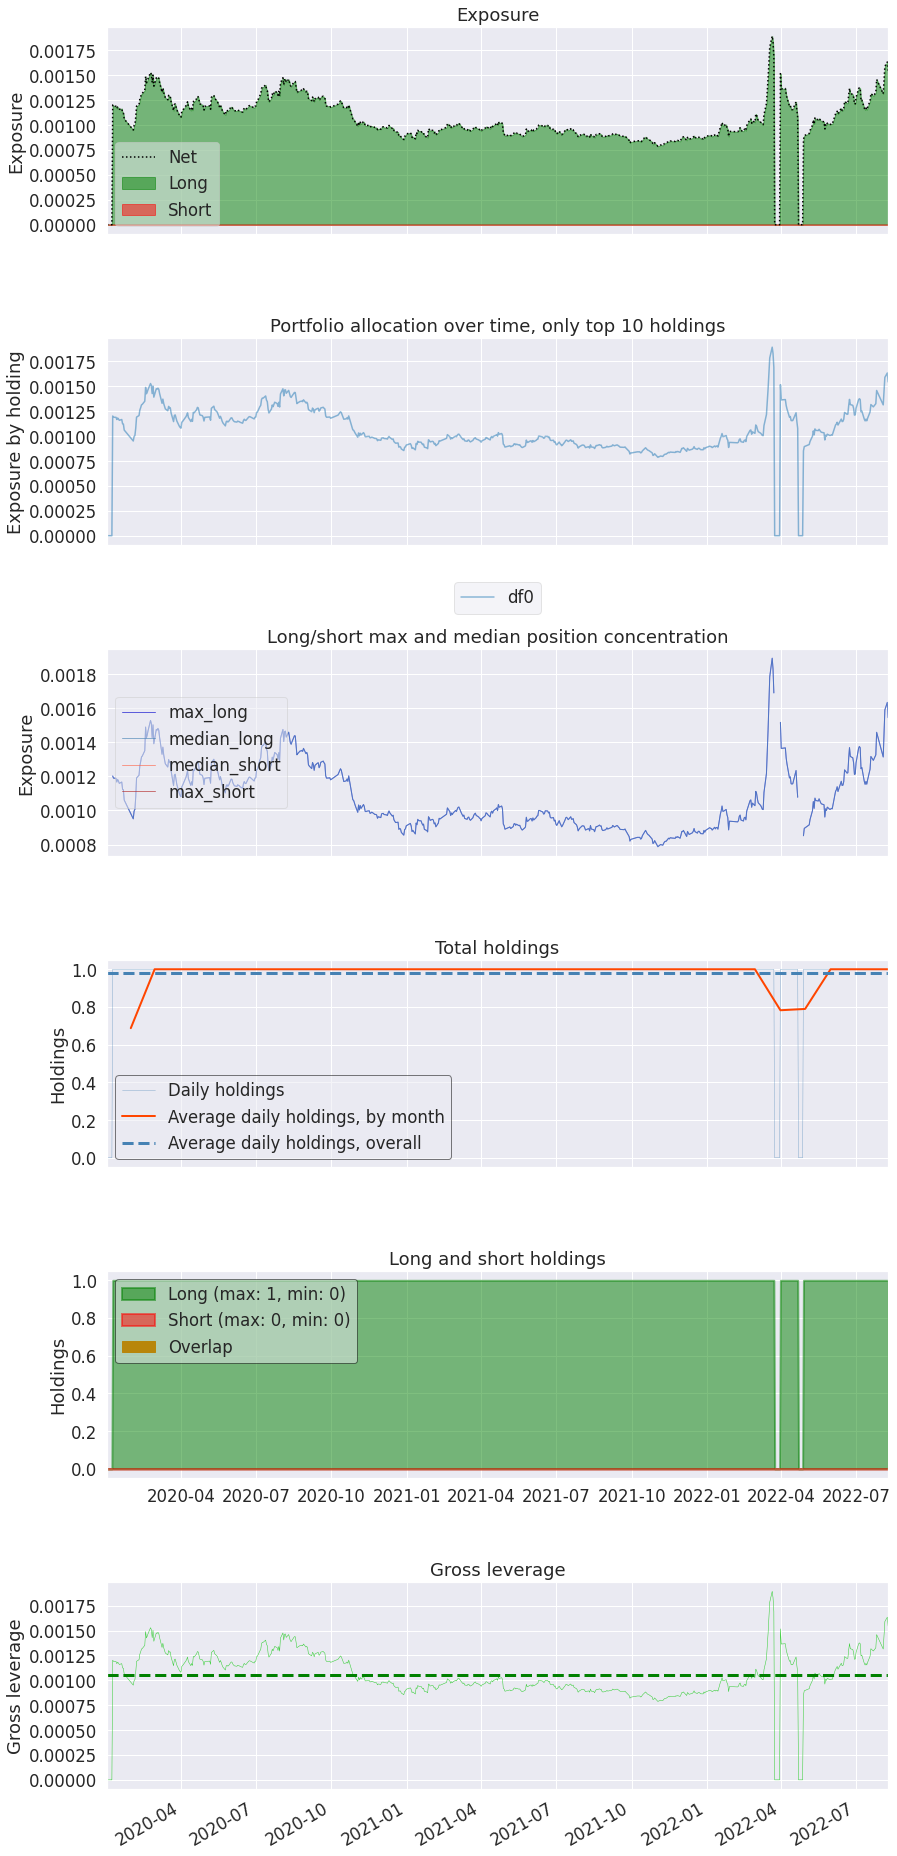

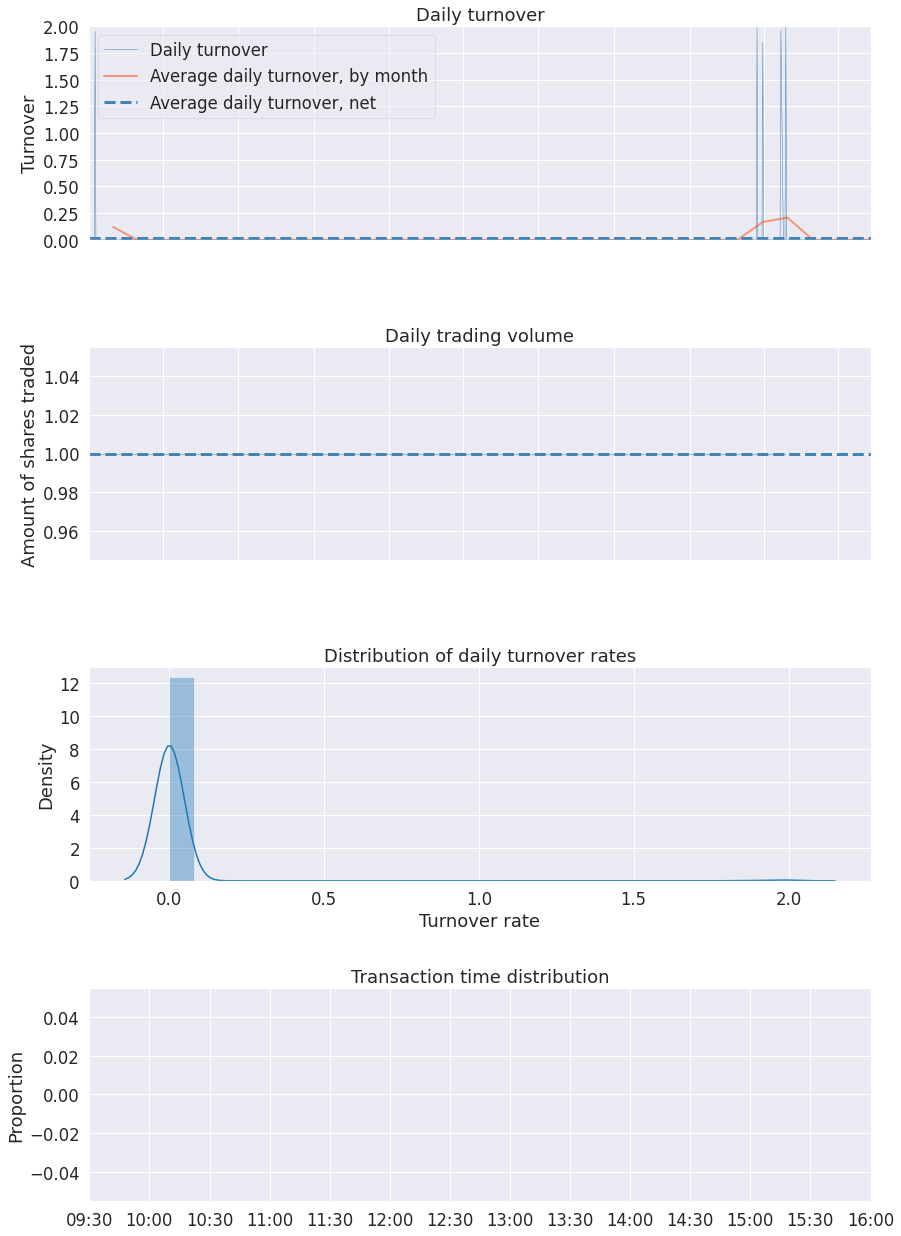

In [16]:
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date='2021-01-01')